In [2]:
import pandas as pd

df = pd.read_csv("AA.Complete Data.csv")
df = df.drop(columns = ["MW Demand"])
df["DATE & TIME"] = pd.to_datetime(df["DATE & TIME"])

# Create Timestamp As Seconds
df["timestamp"] = df["DATE & TIME"].astype("int64") // 10**9
df= df.drop(columns=["DATE & TIME"])

df = df[["timestamp"] + [col for col in df.columns if col != "timestamp"]]
df.head()

,timestamp,Solar Radiation (Wh/m)2,UV Intensity,Atmospheric Clarity,Temperature (2m),Humidity (2M),PS,Wind Speed (10m),Wind Direction (10m),MW Supply
0,1609459200,0.0,0.0,0.37,8.03,6.65,93.99,3.62,85.05,0
1,1609462800,0.0,0.0,0.37,8.01,6.65,94.00,3.50,91.92,0
2,1609466400,0.0,0.0,0.37,8.03,6.65,94.00,3.41,98.58,0
3,1609470000,0.0,0.0,0.37,8.01,6.59,93.98,3.33,101.65,0
4,1609473600,0.0,0.0,0.37,7.92,6.59,93.98,3.26,104.87,0


# Scale and Splt The Data

In [3]:
from sklearn.preprocessing import MinMaxScaler

x = df.drop(columns=["MW Supply"])
y = df["MW Supply"].values.reshape(-1, 1)

# Split 80% train+val and 20% test
train_size = int(0.8 * len(x))
val_size = int(0.1 * train_size)  # 10% of train+val as val

x_train_full, x_test = x[:train_size], x[train_size:]
y_train_full, y_test = y[:train_size], y[train_size:]

# Split train+val into train and val
x_train, x_val = x_train_full[:-val_size], x_train_full[-val_size:]
y_train, y_val = y_train_full[:-val_size], y_train_full[-val_size:]

# Scale using training data only
x_scaler = MinMaxScaler()
x_train_scaled = x_scaler.fit_transform(x_train)
x_val_scaled = x_scaler.transform(x_val)
x_test_scaled = x_scaler.transform(x_test)

y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_val_scaled = y_scaler.transform(y_val)
y_test_scaled = y_scaler.transform(y_test)

how to load scaler: <br>
scaler = joblib.load('scaler.pkl') <br>
scaled_data = scaler.transform(new_data)

# Creating Sequences For CNN

## Create Sequences

In [4]:
import numpy as np
import pandas as pd

def create_sequence(data, labels, look_back):
    sequences = []
    label_values = []

    # Convert Data to Numpy array
    data = data.values if isinstance(data, pd.DataFrame) else data
    labels = labels.values if isinstance(labels, pd.Series) else labels

    for i in range(len(data) - look_back):
        seq = data[i: i + look_back]  # Get past `look_back` time steps
        label = labels[i + look_back]  # Target is the next time step

        sequences.append(seq)
        label_values.append(label)

    return (np.array(sequences), np.array(label_values).reshape(-1, 1))

# Look-back window (e.g., past 24 hours)
look_back = 24

# Create sequences for CNN (same process as LSTM)
X_train_seq, y_train_seq = create_sequence(x_train_scaled, y_train_scaled, look_back)
X_val_seq, y_val_seq = create_sequence(x_val_scaled, y_val_scaled, look_back)
X_test_seq, y_test_seq = create_sequence(x_test_scaled, y_test_scaled, look_back)

# Output shapes
print(f"Training    X shape: {X_train_seq.shape}")
print(f"Training    Y shape: {y_train_seq.shape}")
print(f"Test        X shape: {X_test_seq.shape}")
print(f"Test        Y shape: {y_test_seq.shape}")
print(f"Validation  X shape: {X_val_seq.shape}")
print(f"Validation  Y shape: {y_val_seq.shape}")


Training    X shape: (6284, 24, 9)
Training    Y shape: (6284, 1)
Test        X shape: (1728, 24, 9)
Test        Y shape: (1728, 1)
Validation  X shape: (676, 24, 9)
Validation  Y shape: (676, 1)


# Create CNN Model <br>
Conv1D -> A sliding window that moves across the sequence, applying filters to extract patterns <br>
kernel_size -> Defines the size of the window (filter) that moves over the data, looking at a set number of consecutive values <br>
filters -> Each filter (kernel) learns a different feature from the sequence, and each filter produces a feature map (output) <br>
<br>
MaxPooling1D -> Reduces the size of sequences to help generalization by reducing the input shape <br>
pool_size -> Specifies the size of the window, looking at i sequences and then outputs the highest value <br>
Example: <br>
Input sequence = [1, 2, 3, 4, 5, 6] // pool_size = 2 <br>
The data is split into windows: <br>
    split1 [1, 2] // split2 [3, 4] // split3 [5, 6] <br>
For each window, the maximum value is selected: <br>
    split1 -> [2] // split2 -> [4] // split3 -> [6] <br>
New output sequence = [2, 4, 6] <br>
    This reduces the sequence length by half.

In [52]:
from keras.regularizers import l2
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, GlobalAveragePooling1D, BatchNormalization

model = Sequential()

model.add(Conv1D(filters = 64, kernel_size = 5, activation = "relu", input_shape = (X_train_seq.shape[1], X_train_seq.shape[2]), kernel_regularizer=l2(0.001)))

model.add(MaxPooling1D(pool_size = 2))

model.add(Conv1D(filters = 128, kernel_size = 5, activation = "relu", kernel_regularizer=l2(0.001)))

model.add(MaxPooling1D(pool_size = 2))

model.add(GlobalAveragePooling1D())

model.add(Dense(units = 50, activation = "relu"))
model.add(Dropout(0.3))
model.add(Dense(units = 1))

model.compile(
    optimizer = "adam",
    loss = "huber",
    metrics = ["mae"]
)


# Train The Model

In [53]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping

LR_scheduler = ReduceLROnPlateau(
    monitor = "val_loss",
    factor = 0.5,
    patience = 5,
    min_lr = 1e-6
)

early_stopping = EarlyStopping(
    monitor = "val_loss",
    patience = 5,
    restore_best_weights = True)

history = model.fit(
    X_train_seq,y_train_seq,
    epochs = 50,
    validation_data = (X_val_seq, y_val_seq),
    verbose = 1,
    callbacks = [LR_scheduler, early_stopping],
)

Epoch 1/50
197/197 [==============================] - 2s 5ms/step - loss: 0.0693 - mae: 0.1562 - val_loss: 0.0396 - val_mae: 0.1158 - lr: 0.0010
Epoch 2/50
197/197 [==============================] - 1s 3ms/step - loss: 0.0346 - mae: 0.1175 - val_loss: 0.0284 - val_mae: 0.1042 - lr: 0.0010
Epoch 3/50
197/197 [==============================] - 1s 3ms/step - loss: 0.0249 - mae: 0.1060 - val_loss: 0.0238 - val_mae: 0.1086 - lr: 0.0010
Epoch 4/50
197/197 [==============================] - 1s 4ms/step - loss: 0.0213 - mae: 0.1048 - val_loss: 0.0190 - val_mae: 0.0980 - lr: 0.0010
Epoch 5/50
197/197 [==============================] - 1s 3ms/step - loss: 0.0182 - mae: 0.1012 - val_loss: 0.0157 - val_mae: 0.0840 - lr: 0.0010
Epoch 6/50
197/197 [==============================] - 1s 4ms/step - loss: 0.0162 - mae: 0.0974 - val_loss: 0.0152 - val_mae: 0.0871 - lr: 0.0010
Epoch 7/50
197/197 [==============================] - 1s 4ms/step - loss: 0.0154 - mae: 0.0994 - val_loss: 0.0128 - val_mae: 0.079

# Evaluate Model

In [54]:
from sklearn.metrics import mean_absolute_error

# Predict on train, test, val sequences
y_train_pred_scaled = model.predict(X_train_seq)
y_test_pred_scaled = model.predict(X_test_seq)
y_val_pred_scaled = model.predict(X_val_seq)

# Inverse scale predictions and true values
y_train_pred = y_scaler.inverse_transform(y_train_pred_scaled)
y_test_pred = y_scaler.inverse_transform(y_test_pred_scaled)
y_val_pred = y_scaler.inverse_transform(y_val_pred_scaled)

y_train_true = y_scaler.inverse_transform(y_train_seq)
y_test_true = y_scaler.inverse_transform(y_test_seq)
y_val_true = y_scaler.inverse_transform(y_val_seq)

# Calculate MAE for each dataset
mae_train = mean_absolute_error(y_train_true, y_train_pred)
mae_test = mean_absolute_error(y_test_true, y_test_pred)
mae_val = mean_absolute_error(y_val_true, y_val_pred)

# Calculate mean of true values (for relative error)
mean_train = np.mean(y_train_true)
mean_test = np.mean(y_test_true)
mean_val = np.mean(y_val_true)

# Calculate RMAE
rmae_train = mae_train / mean_train
rmae_test = mae_test / mean_test
rmae_val = mae_val / mean_val

print(f"Training RMAE: {rmae_train * 100:.2f}%")
print(f"Validation RMAE: {rmae_val* 100:.2f}%")
print(f"Testing RMAE: {rmae_test * 100:.2f}%")

22/22 [==============================] - 0s 2ms/step
Training RMAE: 20.07%
Validation RMAE: 23.89%
Testing RMAE: 40.16%


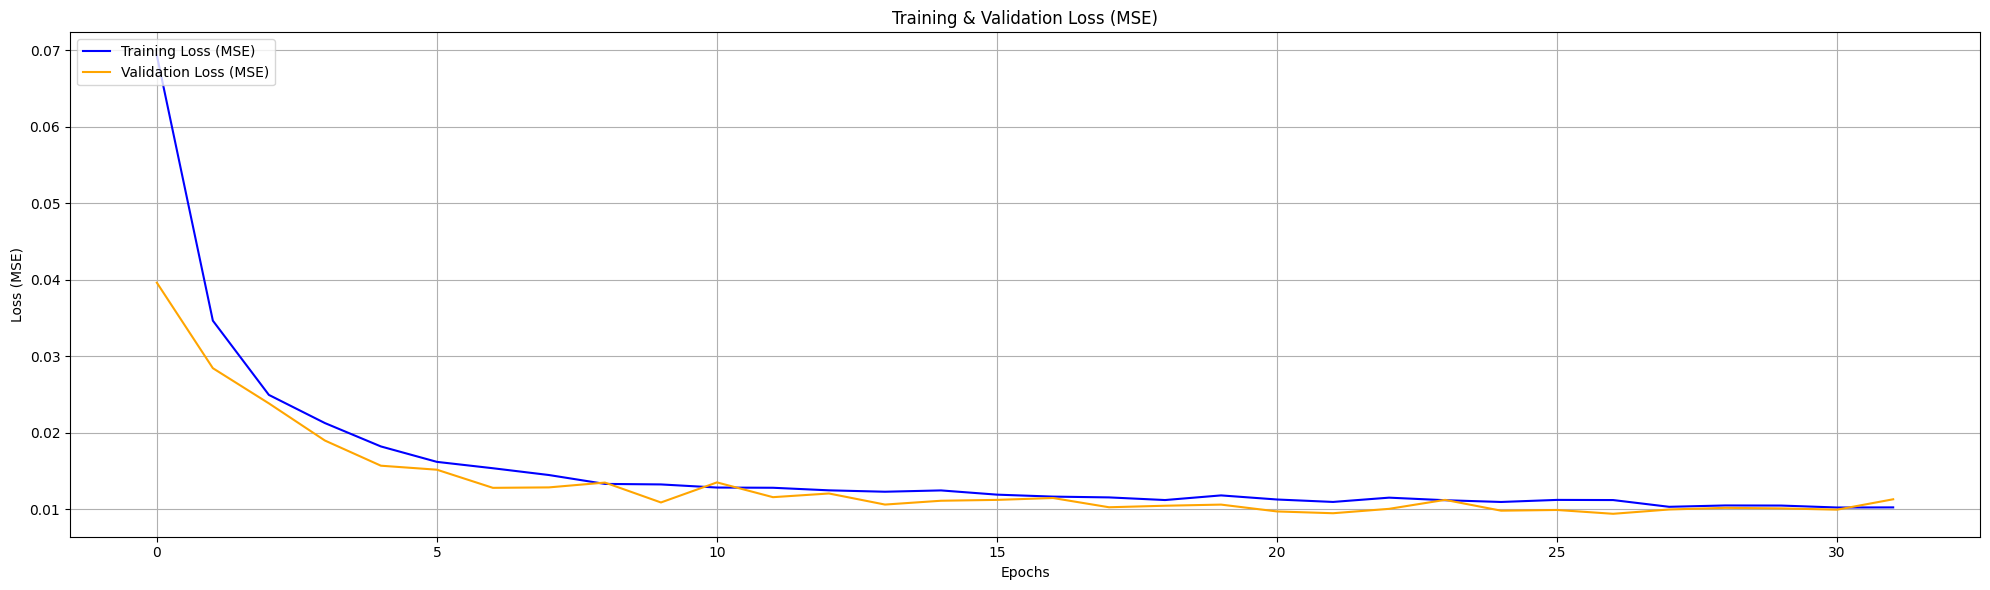

In [55]:
import matplotlib.pyplot as plt

training_loss = history.history["loss"]
val_loss = history.history["val_loss"]
train_rmse = np.sqrt(training_loss)  # RMSE is the square root of the loss (MSE)
val_rmse = np.sqrt(val_loss)  # RMSE for validation

# Plot for Loss
plt.figure(figsize=(20, 6))
plt.plot(training_loss, label="Training Loss (MSE)", color="blue")
plt.plot(val_loss, label="Validation Loss (MSE)", color="orange")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Training & Validation Loss (MSE)")
plt.legend(loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()

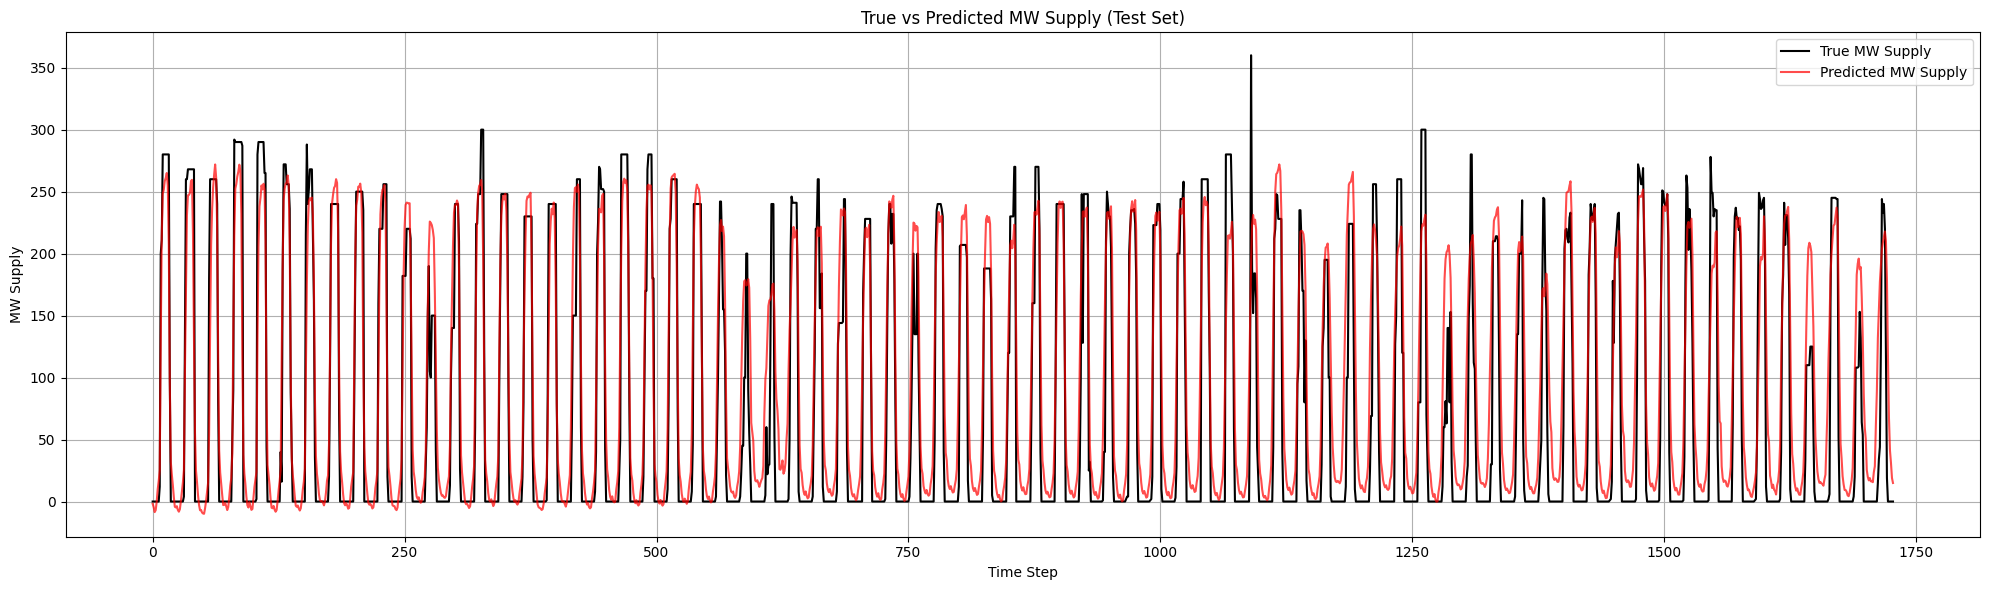

In [56]:
# Plot True vs Predicted for Test Set
plt.figure(figsize=(20, 6))
plt.plot(y_test_true, label="True MW Supply", color="black")
plt.plot(y_test_pred, label="Predicted MW Supply", color="red", alpha=0.7)
plt.xlabel("Time Step")
plt.ylabel("MW Supply")
plt.title("True vs Predicted MW Supply (Test Set)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()